In [2]:
import pandas as pd

df = pd.read_csv('covid_final.csv')

#TODO why are we using all of those variable, whereas it should only have the variables that we need to use for testing. 
X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]
y = df['inc_case']

print(f"X shape: {X.shape}, y shape: {y.shape}")
from sklearn.model_selection import train_test_split

test_size = 0.2  
random_state = 42 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

X shape: (850, 8), y shape: (850,)
X_train shape: (680, 8), y_train shape: (680,)
X_test shape: (170, 8), y_test shape: (170,)


In [4]:
from sklearn.metrics import mean_squared_error

df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})


is_liberal
False    2.130744e+09
True     3.300405e+10
dtype: float64

In [7]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias


grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

(is_liberal
 False    2.130744e+09
 True     3.300405e+10
 dtype: float64,
 is_liberal
 False     46159.979908
 True     181670.159160
 dtype: float64,
             coverage          bias
 is_liberal                        
 False            1.0   5760.264078
 True             1.0 -17190.897910)

In [10]:

metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)


metrics_df


,MSE,RMSE,Coverage,Bias
Conservative,2130743745.07,46159.98,1.00,5760.26
Liberal,33004046729.05,181670.16,1.00,-17190.90


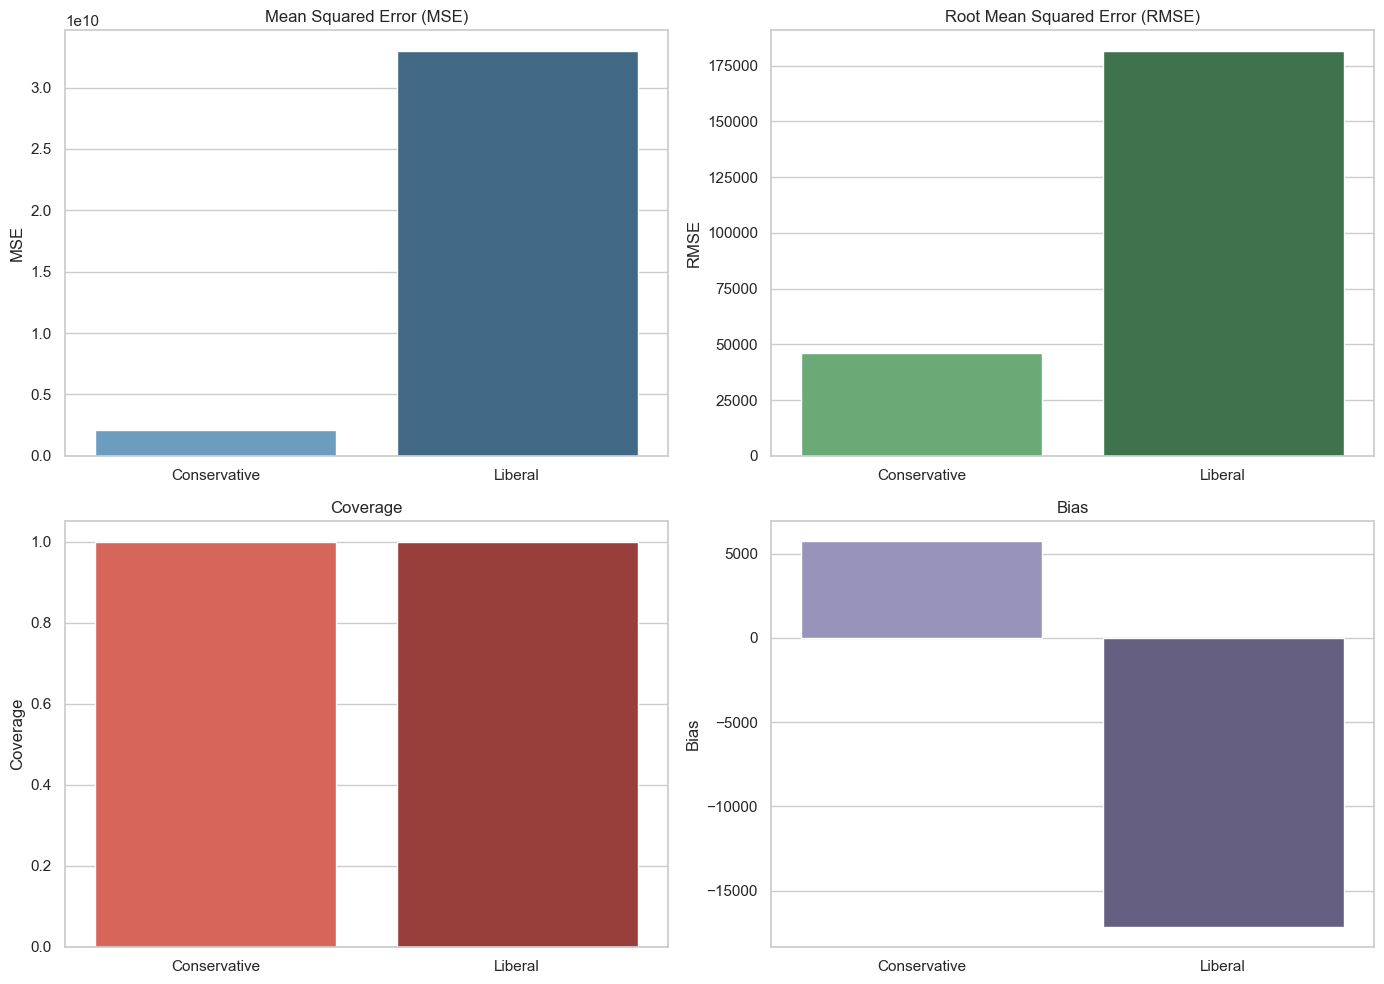

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot Coverage
sns.barplot(x=metrics_df.index, y=metrics_df['Coverage'], ax=axes[1, 0], palette="Reds_d")
axes[1, 0].set_title('Coverage')
axes[1, 0].set_ylabel('Coverage')

# Plot Bias
sns.barplot(x=metrics_df.index, y=metrics_df['Bias'], ax=axes[1, 1], palette="Purples_d")
axes[1, 1].set_title('Bias')
axes[1, 1].set_ylabel('Bias')

# Adjust layout
plt.tight_layout()
plt.show()
